In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    '/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)',
    target_size=(244, 244),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)',
    target_size=(244, 244),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 14927 images belonging to 26 classes.
Found 3715 images belonging to 26 classes.


In [3]:
# Load and Customize InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout to prevent overfitting
output = Dense(26, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Load InceptionV3 Model with fewer frozen layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(244, 244, 3))


In [5]:
# Freeze the first 100 layers (instead of all) to allow learning in later layers
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True

In [6]:
# Add custom layers
x = Flatten()(base_model.output)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
x = Dropout(0.5)(x)  # Dropout rate increased to 0.4 for better regularization
output = Dense(26, activation='softmax')(x)


In [7]:
# Build the final model
model = Model(inputs=base_model.input, outputs=output)

In [8]:
# Compile the model with an increased learning rate for faster learning
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('best_model_inceptionv3.keras', monitor='val_loss', save_best_only=True)

In [9]:
# EarlyStopping and ModelCheckpoint callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_inceptionv3.keras', monitor='val_loss', save_best_only=True)


In [10]:
# Train the model with more epochs
history = model.fit(
    train_data,
    epochs=15,  # Increased epochs for better learning
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1729241846.064735      77 service.cc:145] XLA service 0x7f3b240018a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729241846.064806      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/467 ━━━━━━━━━━━━━━━━━━━━ 9:46:48 76s/step - accuracy: 0.0625 - loss: 9.4153

I0000 00:00:1729241882.773869      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


467/467 ━━━━━━━━━━━━━━━━━━━━ 499s 909ms/step - accuracy: 0.1544 - loss: 16.6161 - val_accuracy: 0.2719 - val_loss: 3.6647
Epoch 2/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 290s 614ms/step - accuracy: 0.3465 - loss: 2.6485 - val_accuracy: 0.3790 - val_loss: 20.9630
Epoch 3/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 288s 610ms/step - accuracy: 0.4967 - loss: 1.9620 - val_accuracy: 0.5952 - val_loss: 1.6016
Epoch 4/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 282s 597ms/step - accuracy: 0.6052 - loss: 1.5617 - val_accuracy: 0.4487 - val_loss: 1084.5581
Epoch 5/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 288s 610ms/step - accuracy: 0.6561 - loss: 1.3728 - val_accuracy: 0.5109 - val_loss: 5.9836
Epoch 6/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 284s 600ms/step - accuracy: 0.6834 - loss: 1.4947 - val_accuracy: 0.6170 - val_loss: 4.2573
Epoch 7/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 291s 616ms/step - accuracy: 0.7500 - loss: 1.0261 - val_accuracy: 0.7184 - val_loss: 1.0832
Epoch 8/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 287s 608ms/step - accuracy: 0.7656 - loss:

In [11]:
# Save the trained model
model.save('freshness_detection_model_inceptionv3.h5')

In [12]:
# Evaluate Model on Test Data (after training)
test_data = val_data  # Assuming val_data also serves as test data in this example
test_data.reset()
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=-1)

test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy:.2f}')

117/117 ━━━━━━━━━━━━━━━━━━━━ 66s 520ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 57s 484ms/step - accuracy: 0.7570 - loss: 0.8881
Test accuracy: 0.76


In [13]:
# Print Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {test_accuracy:.4f}")


Accuracy: 0.0415


In [14]:
# Calculate other Evaluation Metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(to_categorical(y_true), model.predict(test_data), multi_class='ovr')
log_loss_value = log_loss(to_categorical(y_true), model.predict(test_data))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")


100/117 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


117/117 ━━━━━━━━━━━━━━━━━━━━ 56s 477ms/step
 39/117 ━━━━━━━━━━━━━━━━━━━━ 38s 496ms/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


117/117 ━━━━━━━━━━━━━━━━━━━━ 55s 468ms/step
Precision: 0.0406
Recall: 0.0415
F1 Score: 0.0388
ROC AUC: 0.4947
Log Loss: 10.2525


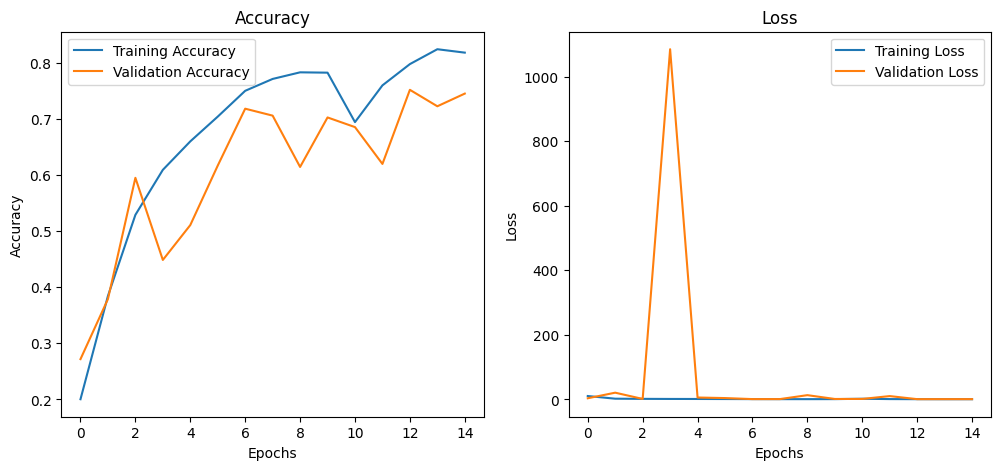

In [15]:
# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()